# Statistical Models and Model Estimation
Adapted by F. Burkholder from Matthew Drury's Maximum Likelihood Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optim

from itertools import product

# Always make it pretty.
plt.style.use('ggplot')

## Review

What is the difference between probability and statistics?

1. In **----blank----** we *know* the parameters of a distribution (associated with some random variable), and we would like to study properties of data generated from that distribution.  
<br>
2. In **----blank---** we have data generated from a random variable, and we would like to *infer/estimate* properties of its distribution.



<details>
    <summary>
    Click for solution.
    </summary>
1. probability <br>    
2. statistics  <br>
Probability: Model --> P(outcome) <br>
Statistics: Data --> Model
</details>

What would you be using (probability or statistics) to answer the following questions?  

1. A coin is flipped 100 times, and comes up heads 55 times.  Is it fair?  
2. You go to play craps in Vegas, using 2 fair dice.  What's the chance you'll roll snake eyes (1 and 1) on your first roll?

<details>
    <summary>
    Click for solution.
    </summary>
1. statistics <br>    
2. probability
</details>

Would you use statistics or probability to answer this one?  
<br>
While getting ready for work, after waking up at 6:00, you observe busses stopping at your bus stop at 6:12, 6:15, 6:20, 6:21, and 6:30, after which you leave to the bus stop at 6:33.  What is the probability you will have to wait longer than 5 minutes for the next bus?

<details>
    <summary>
    Click for solution.
    </summary>
You'd use both. Statistics first, to determine the model, and then probability to determine the probability of an outcome.  <br>
Data --> Model --> P(outcome)  
<br>
But what should the model be???
</details>

The process for solving a problem like the bus problem above is:

1. Use domain knowledge/creativity to create a **statistical model** for your data, this is a *catalogue* of possible ways that the data may have been generated.
2. **Fit** the statistical model to the data.  This selects **exactly one** of the data generating processes from your catalogue and determines its parameters. 
3. Use the fit model to **compute** the thing you want.  Now we are using it in a probabilistic way.

Maximum Likelihood Estimation (MLE) - what most of this lecture is about - helps with step 2.

## Lecture Objectives

* Be able to explain what a statistical model is and why we use it.
* Understand that Maximum Likelihood Estimation (MLE) is a method used in statistics to determine statistical model parameters from data.  
* Be able to use MLE to estimate model parameters given a statistical model and data.
* Make you comfortable explaining MLE and using it.
* Give you some interesting Python to learn from in the process.

## Introductory Definitions


A **statistical model** is a collection of random variables, each of which is hypothesized to possibly have generated the data.  Different random variables in the collection are usually distinguished by **parameters**.

For example, we might have data that we think was generated by a normal distribution.  So from the data, we would need to determine the parameters that defines the normal distribution (mean, standard deviation).

**Fitting a statistical model to data** is any process that combines a model with data, and uses the data to select one and only one random variable from the model.  This often takes the form of **determining the parameters for one and only one of the random variables in the model**.  These estimated values of the parameters are called **parameter estimates**.

**Warning from Matt:** This terminology is one of the *most abused* in all of statistics.  Formally, the *model* is a **collection** of possible data generating process, but *everyone* also refers to the *single* object you get after fitting the model to data as "the model".  **Seriously everyone does this**, but it's technically incorrect.

### Statistical Model Example: Normal Distribution with Unknown Mean, and Known Variance.

Let's fit a model to data as part of a thought experiment.  We suspect that our data is generated from a normal distribution with **unknown mean**, but we know the variance is $1$ (this is not something you can generally know, we're assuming it for simplicity in the thought experiment.  We have only one paramater to estimate: the **mean**).

Then, our **statistical model** is the following collection of random variables:

$$ M = \{ \text{Normal}(\mu, 1) \mid \mu \in \mathbb{R} \} $$

The **parameter** at play is the unknown mean of the normal distribution (since we are assuming we know the variance, that's not a parameter).


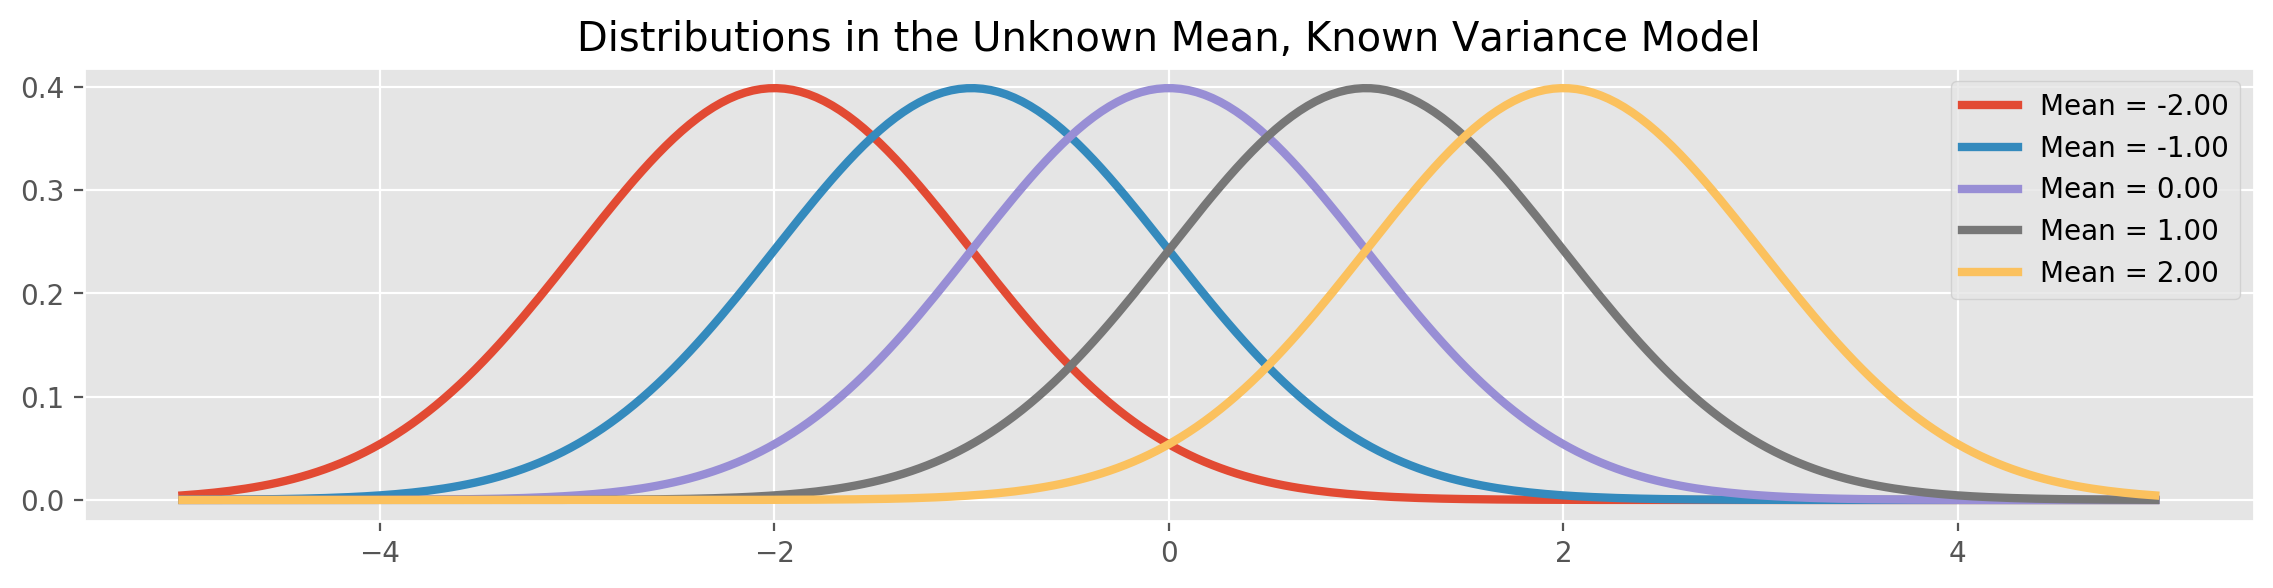

In [4]:
# let's make some random variables parameterized by different means
x = np.linspace(-5, 5, num=250)
fig, ax = plt.subplots(figsize=(14, 3), dpi=200)

means = np.linspace(-2, 2, num=5)
for mean in means:
    normal = stats.norm(mean, 1)
    ax.plot(x, normal.pdf(x), label="Mean = {:2.2f}".format(mean), linewidth=3)
    
ax.legend()
ax.set_title("Distributions in the Unknown Mean, Known Variance Model"); # semicolon prevents text output

By **fitting the model to data** we mean any process that selects exactly *one* of these distributions.  This reduces, in this case, to selecting the mean parameter $\mu$ of the unknown normal distribution.  

Optimization methods, such as Maximum Likelihood Estimation, have a mathematically rigorous way to select the right parameter.  

Right now we're trying to build your intutition about the process. So we're going to first illustrate the selection of parameter using the the slightly hand-wavy **eyeball method**.

## The Eyeball Method

Let's fit our model with the **eyeball method.** We will sample new data sets of the same size as our data from normal distributions of varying mean, and then pick the distribution that best resembles our data.  
<br>
Using our eyeballs, we're going to compare data generated by normal distributions of varying means to the data that we got, and pick whichever mean gives us data most similar to the data we got.

In [29]:
# helper functions

def text_in_blank_plot(text, ax):
    _ = ax.text(0.5, 0.5, text, 
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=22)
    ax.axis('off')

def one_dim_scatterplot(data, ax, jitter=0.2, **options):
    # jitter is a nice way to show data that's one dimensional and stacked on top of each other
    if jitter:
        jitter = np.random.uniform(-jitter, jitter, size=data.shape)
    else:
        jitter = np.repeat(0.0, len(data))
    ax.scatter(data, jitter, **options)
    ax.yaxis.set_ticklabels([])
    ax.set_ylim([-1, 1])
    
def empirical_distribution(x, data):
    '''Cumulative distribution for the data'''
    weight = 1.0 / len(data)
    count = np.zeros(shape=len(x))
    for datum in data:
        count = count + np.array(x >= datum)
    return weight * count

In [7]:
# Let's make the true data that we will fit. Pretend you didn't see this!!!!
mu = 0.1      #population mean - the real one! (the one we are trying to find)
sigma = 0.9   #population standard deviation - the read one (not 1, btw)
norm = stats.norm(mu, sigma)
data = norm.rvs(100)   # randomly sample 100 data points

#### We're using [subplot2grid](https://matplotlib.org/3.1.1/gallery/userdemo/demo_gridspec01.html#sphx-glr-gallery-userdemo-demo-gridspec01-py) to make our plot.

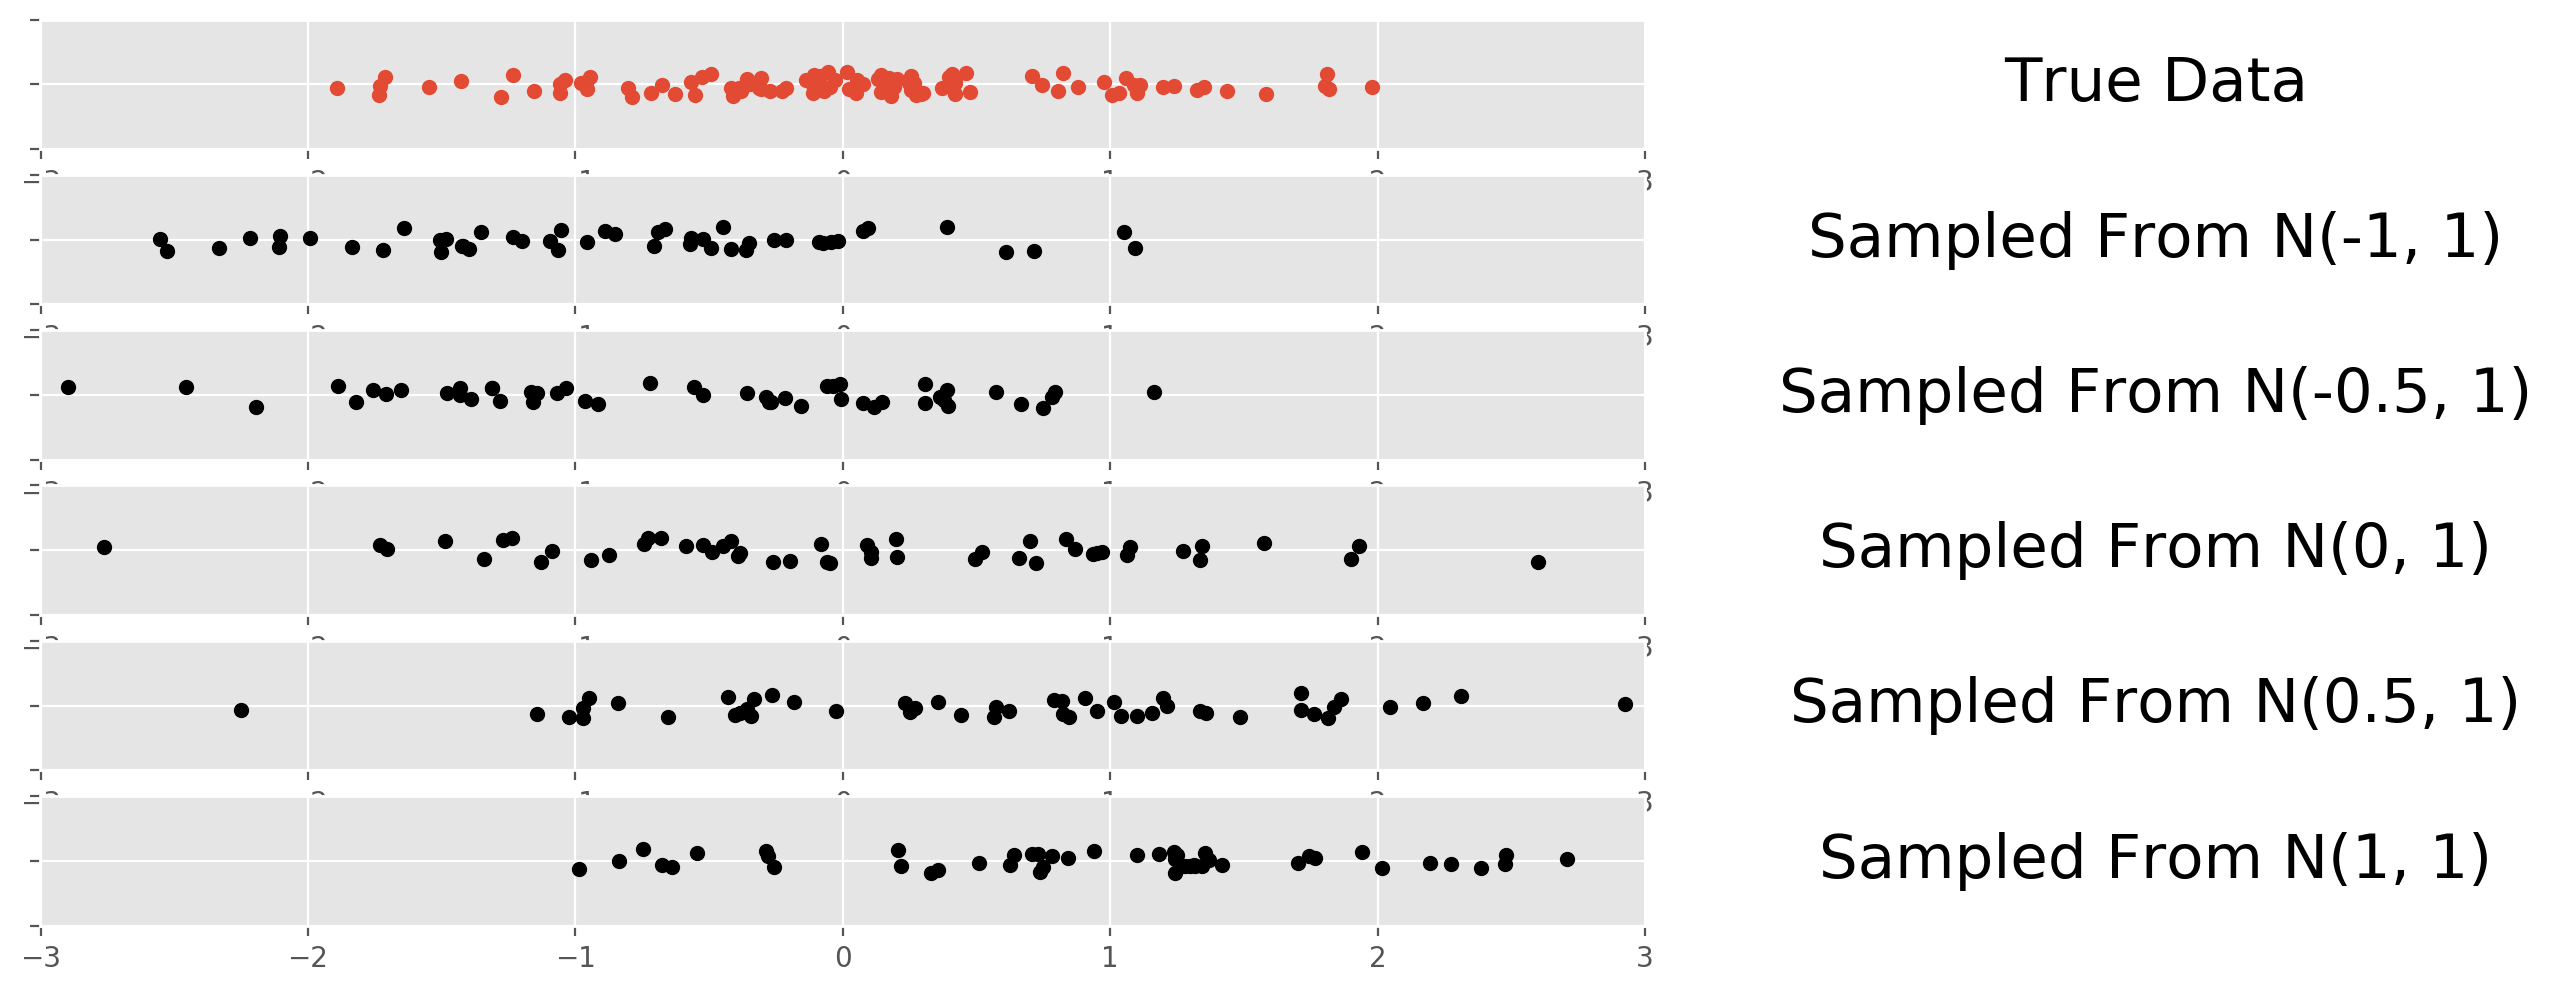

In [8]:
means = [-1, -0.5, 0, 0.5, 1]  # the means we are going try

fig = plt.figure(figsize=(16, 6), dpi=200) 
ax = plt.subplot2grid((6, 3), (0, 0), colspan=2)
ax.set_xlim(-3, 3)
one_dim_scatterplot(data, ax, s=25) # plots true data
ax = plt.subplot2grid((6, 3), (0, 2), colspan=1)  # see subplot2grid above
text_in_blank_plot("True Data", ax)

# getting data consistent with each of the means above
for i, mu in enumerate(means):
    normal = stats.norm(mu, 1)
    sample = normal.rvs(50)
    ax = plt.subplot2grid((6, 3), (i + 1, 0), colspan=2)
    ax.set_xlim(-3, 3)
    one_dim_scatterplot(sample, ax, s=25, c="black")   
    ax = plt.subplot2grid((6, 3), (i + 1, 2), colspan=1)
    text_in_blank_plot("Sampled From N({}, 1)".format(mu), ax)

Which mean gives data most similar to the True Data?

Another way to eyeball is to compare the **empirical CDF** to the actual CDFs of the canidate distributions.

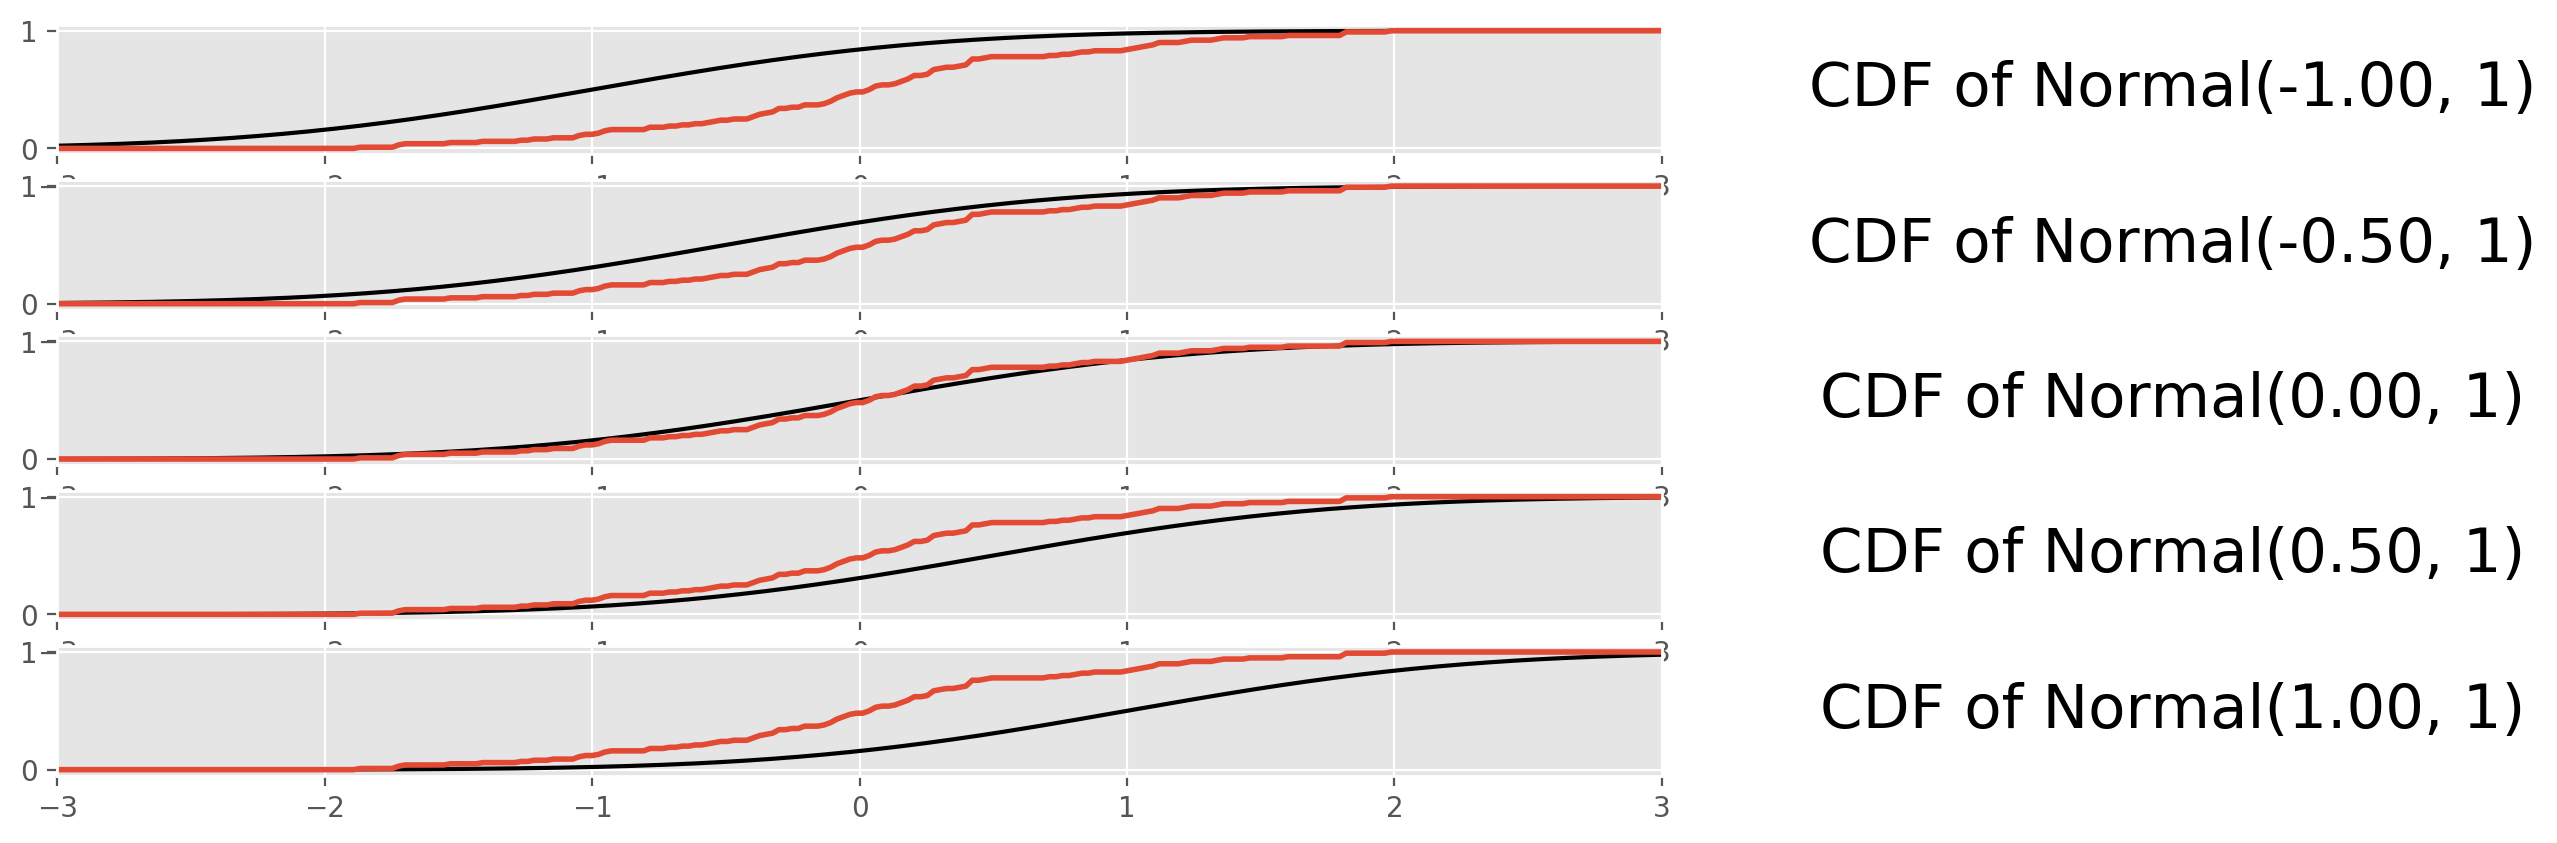

In [9]:
means = [-1, -0.5, 0, 0.5, 1]

fig = plt.figure(figsize=(16, 6), dpi=200) 

x = np.linspace(-3, 3, num=250)

for i, mu in enumerate(means):
    normal = stats.norm(mu, 1)
    ax = plt.subplot2grid((6, 3), (i + 1, 0), colspan=2)
    ax.set_xlim(-3, 3)
    ax.plot(x, normal.cdf(x), color="black")
    ax.plot(x, empirical_distribution(x, data), linewidth=2)
    ax = plt.subplot2grid((6, 3), (i + 1, 2), colspan=1)
    text_in_blank_plot("CDF of Normal({:2.2f}, 1)".format(mu), ax)

It's kind of hard to eyeball here, but it looks like $N(0, 1)$ is our best choice.

This eyeball method clearly has some downfalls

  - To make it feasible, we needed discrete values of $\mu$ we were considering to a small set.  It would be better to consider *all* the possible $\mu$'s at once.
  - If there were more parameters, mean and variance for example, the number of candidate distributions we needed to consider would grow exponentially.
  - It's hard to eyeball which candidate looks best by comparing simulated to real data.  Better would be a disciplined measurement of "how different are the datasets?".

Let's get mathematically much more rigorous.

## The Maximum Likelihood Method

The **maximum likelihood method** is the gold standard method for fitting statistical models to data.  Almost all models used in modern times use some version of the maximum likelihood method.

Our goal is to make the following philosophy of model fitting precise

> The fit model should be the random variable *most likely* to generate the data.

We already know how to generate data, this is just *sampling*, so we need to make the phrase *most likely* precise.

Consider the following density function of a **normal** distribution.

**What is the data value most likely to be generated when sampling from this distribution?**

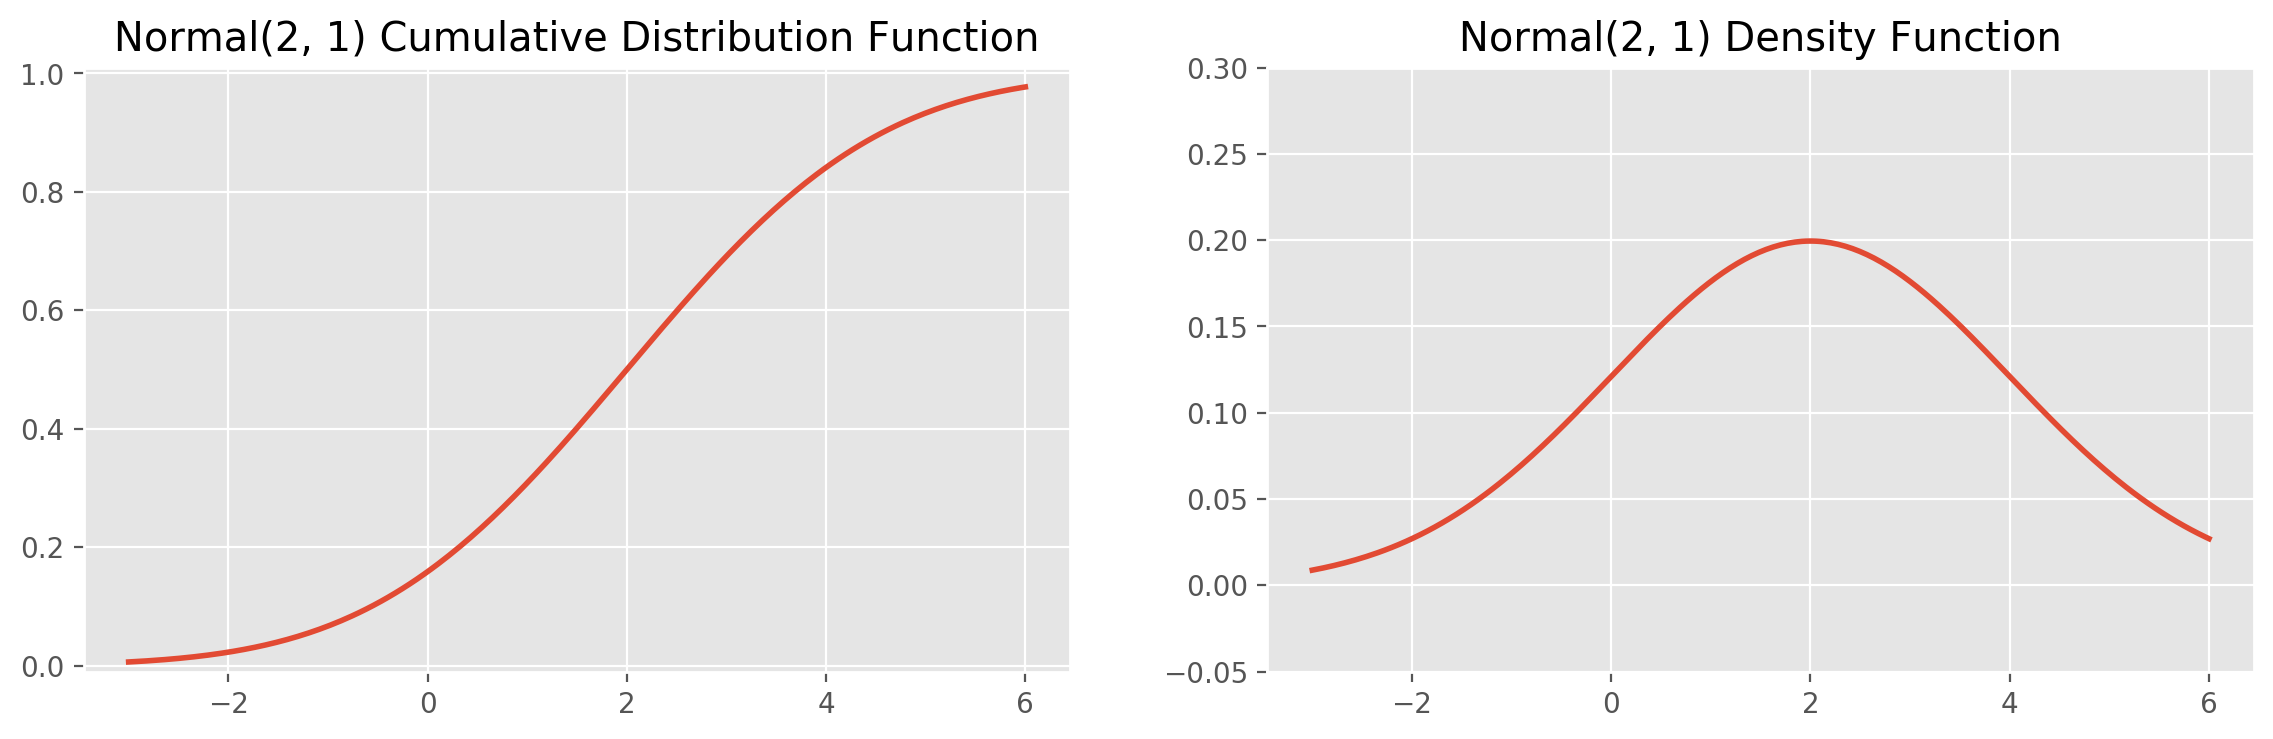

In [15]:
normal = stats.norm(2, 2)  # mean, standard deviation

x = np.linspace(-3, 6, num=250)
fig, ax = plt.subplots(1, 2, figsize=(14, 4), dpi=200)


ax[0].plot(x, normal.cdf(x), linewidth=2)
ax[0].set_ylim(-0.01, 1.01)
ax[0].set_title("Normal(2, 1) Cumulative Distribution Function")

ax[1].plot(x, normal.pdf(x), linewidth=2)
ax[1].set_ylim(-0.05, 0.3)
ax[1].set_title("Normal(2, 1) Density Function");

Consider a single data value, represented in the plots below as a large black dot.   
<br> **Which normal distribution is most likely to have generated this data point**? (Note that this the reverse question of the first.)

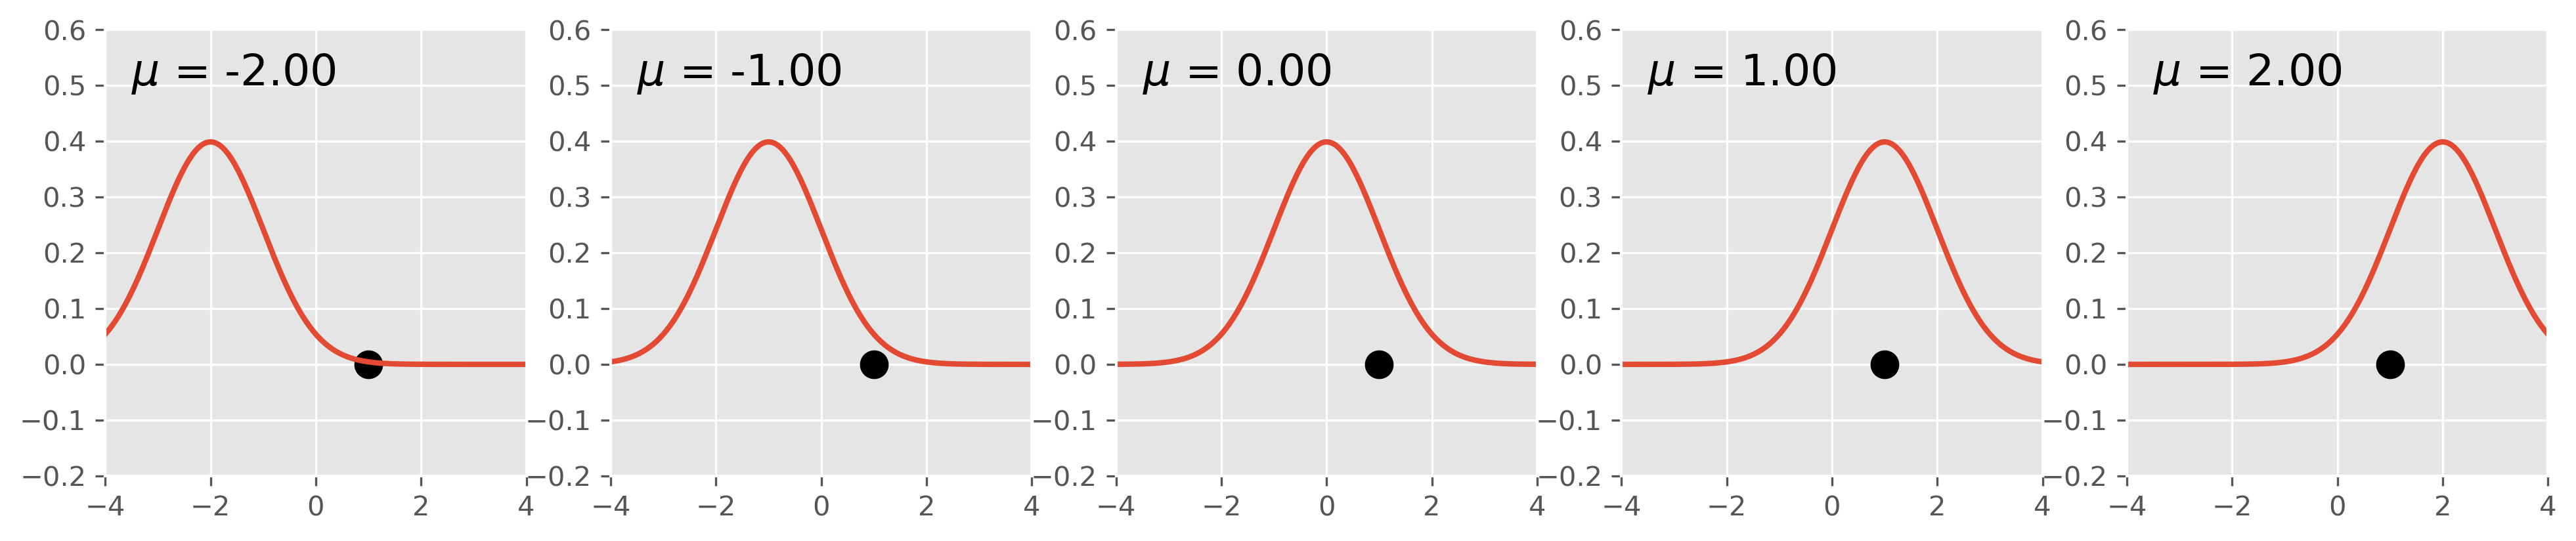

In [17]:
datapt = 1 # value of a datapoint of interest

mus = [-2, -1, 0, 1, 2]  # means to try
normal_dists_varying_mean = [stats.norm(mu, 1) for mu in mus] 

x = np.linspace(-4, 4, num=250)
fig, axs = plt.subplots(1, 5, figsize=(16, 3), dpi=300)

for i, ax in enumerate(axs.flatten()):
    ax.plot(x, normal_dists_varying_mean[i].pdf(x), linewidth=2)
    ax.scatter(datapt, [0], s=100, c="black")
    ax.set_ylim(-0.2, 0.6)
    ax.set_xlim(-4, 4)
    ax.text(-3.5, 0.5, r"$\mu$ = {:2.2f}".format(mus[i]),
            fontsize=16)

The distribution most likely to generate the point is, intuitively, the one where the *mode* of the distribution *coincides with* the data value.

To find the distribution that is most likely to have generated a data point $x$, we find the parameter $\theta$ that maximizes the density function (pdf) evaluated at $x$

$$ \text{maximize by finding} \ \theta \ \{ f(x; \theta) \} $$

Said another way, we pick whatever value of $\theta$ maximizes the likelihood of our observed data $x$.

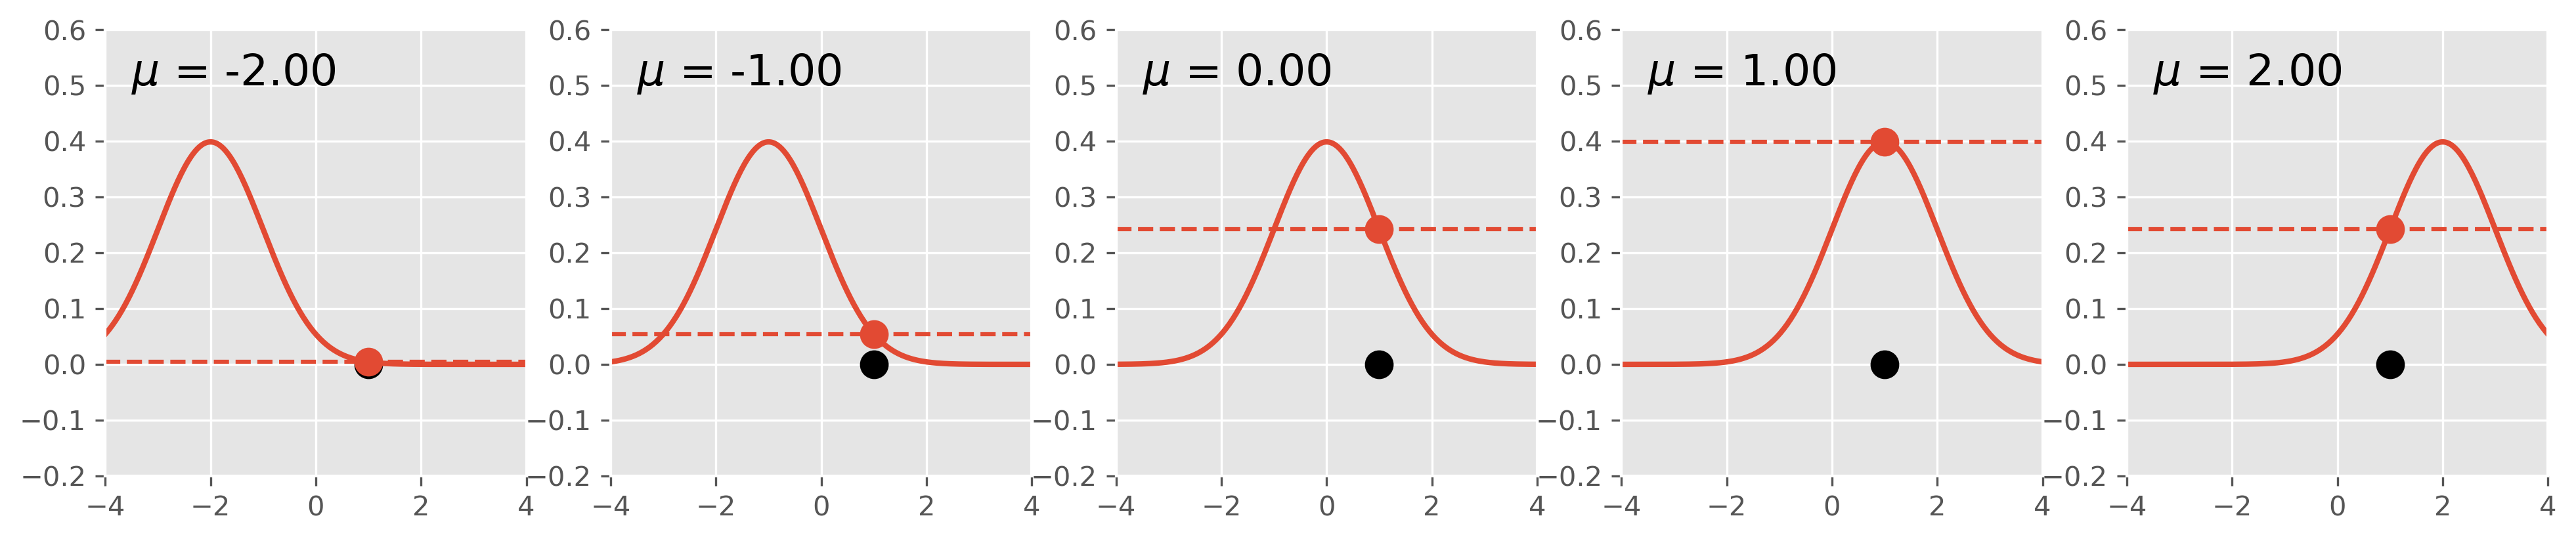

In [18]:
normal_dists_varying_mean = [
    stats.norm(mu, 1) for mu in [-2, -1, 0, 1, 2]
]

x = np.linspace(-4, 4, num=250)
fig, axs = plt.subplots(1, 5, figsize=(16, 3), dpi=300)

for i, ax in enumerate(axs.flatten()):
    ax.plot(x, normal_dists_varying_mean[i].pdf(x), linewidth=2)
    ax.scatter([1], [0], s=100, c="black")
    ax.scatter([1], [normal_dists_varying_mean[i].pdf(1)], s=100)
    ax.axhline(y=normal_dists_varying_mean[i].pdf(1), linestyle="--") 
    ax.set_ylim(-0.2, 0.6)
    ax.set_xlim(-4, 4)
    ax.text(-3.5, 0.5, r"$\mu$ = {:2.2f}".format(mus[i]),
        fontsize=16)

When our data $x$ is fixed, and we are thinking of changing $\theta$, we call this the **likelihood function**.

$$ L(\theta) = f(x; \theta) $$

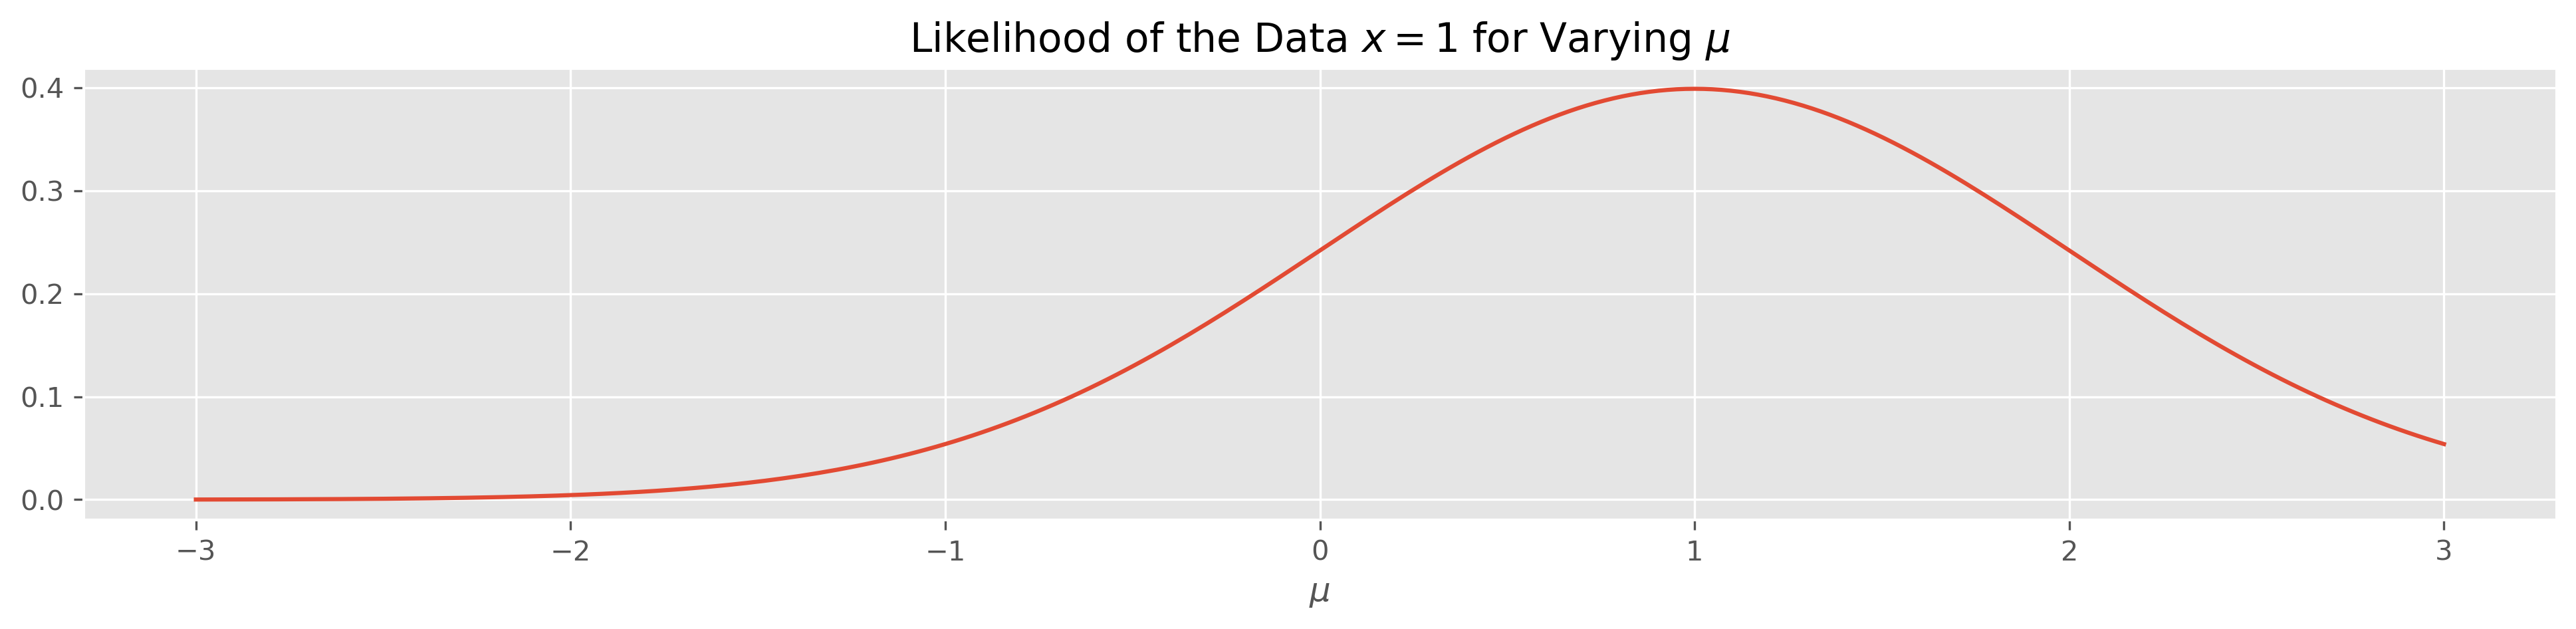

In [20]:
fig, ax = plt.subplots(figsize=(16, 3), dpi=300)

x = 1  # This is the fixed data
t = np.linspace(-3, 3, num=250)

def likelihood(mu):
    '''Note that the likelihood is just the pdf of the distribution'''
    normal = stats.norm(mu, 1)
    return normal.pdf(x)

ax.plot(t, likelihood(t))
ax.set_title("Likelihood of the Data $x = 1$ for Varying $\mu$")
ax.set_xlabel("$\mu$");

### Definition

Suppose $M$ is a statistical model, with a parameter $\theta$.  Then each of the random variables in the model has a density function, and the parameter $\theta$ appears in the density function

$$ f(x_i; \theta) $$

Denote by $x_i$ a set of data.

The **likelihood function of the model given the data** is a function of the **parameter**, it informally measures the likelihood of observing the data you have as you vary the parameters in the model

$$ L(\theta) = \prod_i f(x_i; \theta) $$

For example, if we're fitting a normal distribution (with unknown mean, but known variance one) to three data points:

$$ x_1 = 0.2,\quad x_2 = -1.2,\quad x_3 = -1.5 $$

Then our [likelihood function](https://en.wikipedia.org/wiki/Normal_distribution) would be:

$$ L(\mu) = \frac{1}{\sqrt{2 \pi}} e^{ - \frac{(0.2 - \mu)^2}{2}}
\times \frac{1}{\sqrt{2 \pi}} e^{ - \frac{(-1.2 - \mu)^2}{2}}
\times \frac{1}{\sqrt{2 \pi}} e^{ - \frac{(-1.5 - \mu)^2}{2}}
$$

In practice, the log-likelihood is more useful because it turns products into sums, and sums are easier to work with:

$$ LL(\theta) = \sum_i \log( f(x_i, \theta) ) $$

In our example, using the [Laws of Logarithms](https://www.chilimath.com/lessons/advanced-algebra/logarithm-rules/) we get:

$$ LL(\mu) = - \frac{3}{2} \log(2 \pi) - \frac{(0.2 - \mu)^2}{2} - \frac{(1.2 - \mu)^2}{2} - \frac{(-1.5 - \mu)^2}{2} $$

To **fit a model by the likelihood method we find the parameters $\theta$ that maximize the likelihood function**.

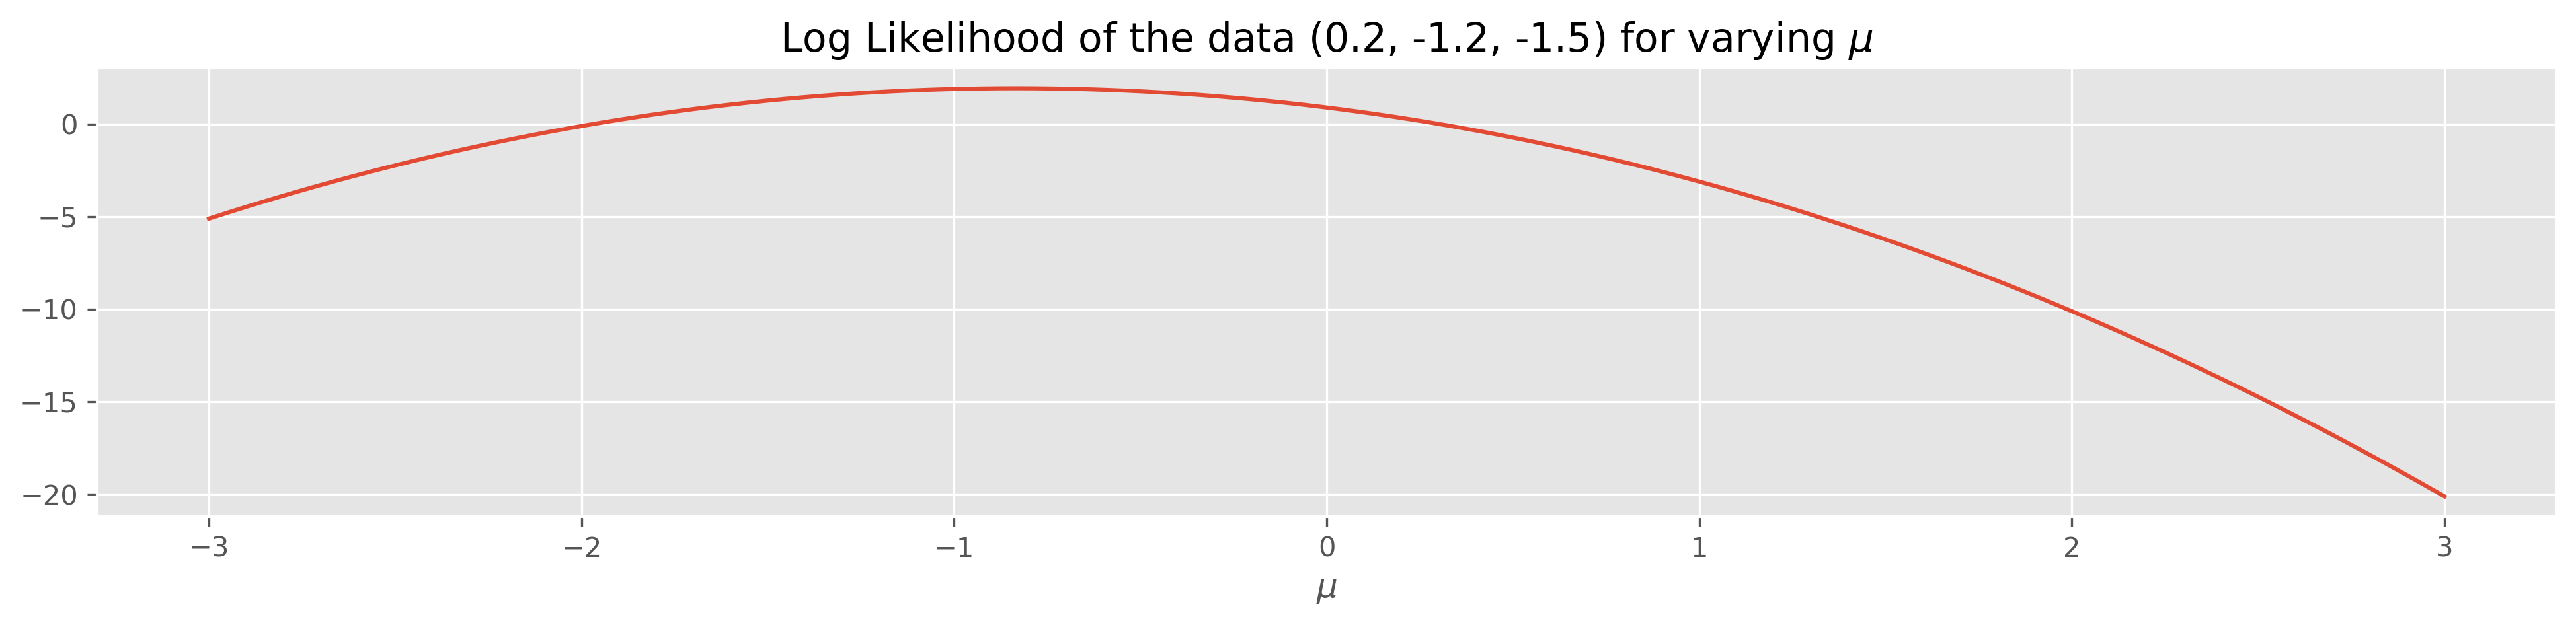

In [21]:
fig, ax = plt.subplots(figsize=(16, 3), dpi=300)

t = np.linspace(-3, 3, num=250)

def log_likelihood(mu):
    return 3 / 2 * np.log(2 * np.pi) - ((0.2 - mu)**2)/2 - ((-1.2 - mu)**2)/2 - ((-1.5 - mu)**2)/2

ax.plot(t, log_likelihood(t))
ax.set_title("Log Likelihood of the data (0.2, -1.2, -1.5) for varying $\mu$")
ax.set_xlabel("$\mu$");

Where does the Maximum Log Likelihood occur?

### Back to Example: Manual MLE on Normal Distribution, Unknown Mean, Std=1

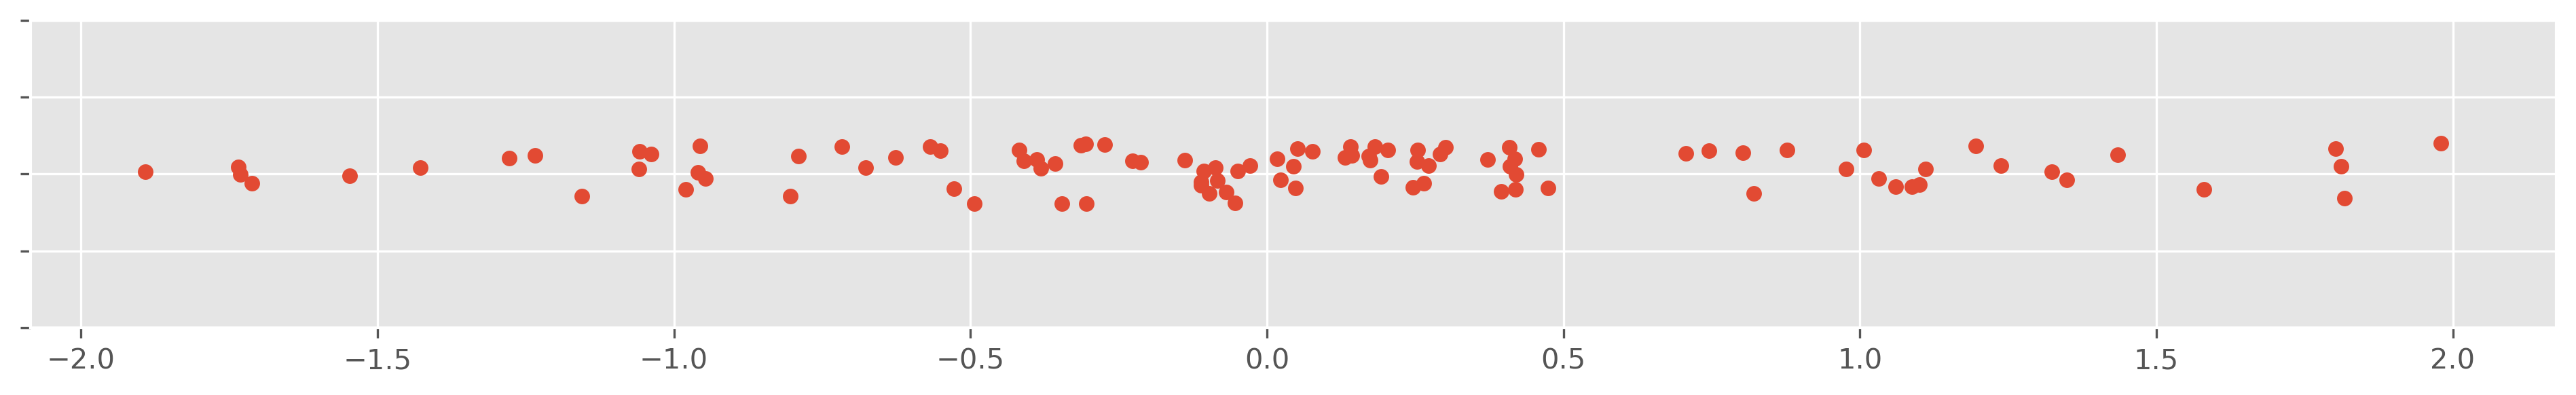

In [22]:
fig, ax = plt.subplots(1, figsize=(16, 2), dpi=300)
one_dim_scatterplot(data, ax, s=25)

And attempt to fit a normal distribution to this data using the likelihood method.

#### Step 1: Write down the model.

Our model contains all normal random variables.  We will assume the varaince is knows (in particular, we'll assume it is one), but the mean is unkown.

$$ M = \{ N(\mu, 1) \mid \mu \in \mathbb{R} \} $$

#### Step 2: Write down the density functions of all the random variables in the model.

The density function of a normal distribution with unknown mean and variance is:

$$ f(t; \mu) = \frac{1}{\sqrt{2 \pi}} e^{ - \frac{(t - \mu)^2}{2}} $$

This pdf has arguments for both the **data** and the **parameter**:

$$ f(\underbrace{t}_{\text{data}}; \underbrace{\mu}_{\text{parameter}}) $$

I can access this function in python by using `stats.norm(mu, 1)`.

#### Step 3: Write code to compute the log likelihood function of the model given the data (you're doing this "manually" for now)

Remember that the data is *fixed* and we want to vary the *parameters*, so the way we write our function should respect that.

In [24]:
def log_likelihood_normal_one_parameter(mu):
    normal = stats.norm(mu, 1.0)
    likelihoods = [normal.pdf(datum) for datum in data] # just use pdf for likelihood!
    return np.sum(np.log(likelihoods))

The mean 0.04 maximimized the log likelihood.


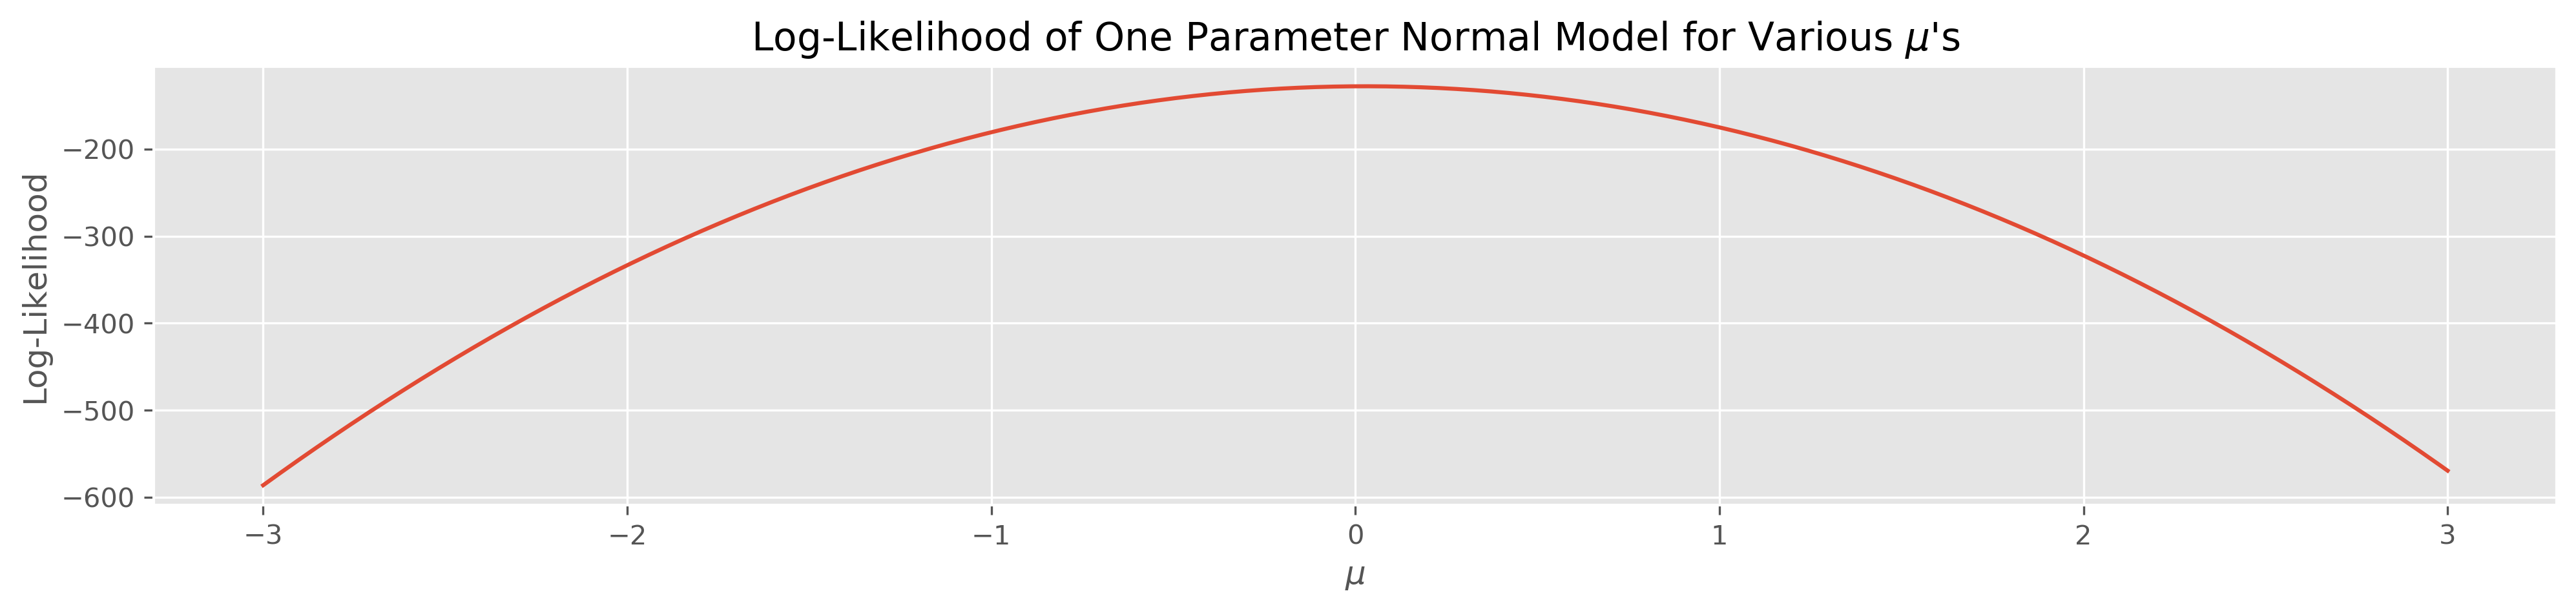

In [25]:
mus = np.linspace(-3, 3, num=250)
llhs = [log_likelihood_normal_one_parameter(mu) for mu in mus]

fig, ax = plt.subplots(figsize=(16, 3), dpi=300)
ax.plot(mus, llhs)

ax.set_xlabel(r"$\mu$")
ax.set_ylabel("Log-Likelihood")
ax.set_title(r"Log-Likelihood of One Parameter Normal Model for Various $\mu$'s")

maxllh_index = np.argmax(llhs)
mu_maxllh = mus[maxllh_index]
print(f"The mean {mu_maxllh:0.2f} maximimized the log likelihood.")

#### Step 4: Find the parameters that maximize the log-likelihood.

Eyeballing our simple grid search above, it seems like $\mu = 0$ is the best of what we tried.

In practice, we use an algorithm like **gradient descent** to find a good approximation to the maximal parameters, this process is called **optimization**.

In python, we can use built in optimizer to find the maximal parameters.

In [27]:
def minus_log_likelihood_normal_one_parameter(mu):
    # optim does gradient descent, not gradient ascent
    return -log_likelihood_normal_one_parameter(mu)

# The optimizer needs a function that consumes a single numpy array
def wrapper_for_scipy_one_parameter(x):
    return minus_log_likelihood_normal_one_parameter(x[0])

fit_parms = optim.minimize(wrapper_for_scipy_one_parameter, (0,), method='Nelder-Mead')
mu_hat = fit_parms.x

print("Log-Lik Optimal Parameters: mu = {0:2.3f}".format(mu_hat[0]))

Log-Lik Optimal Parameters: mu = 0.028


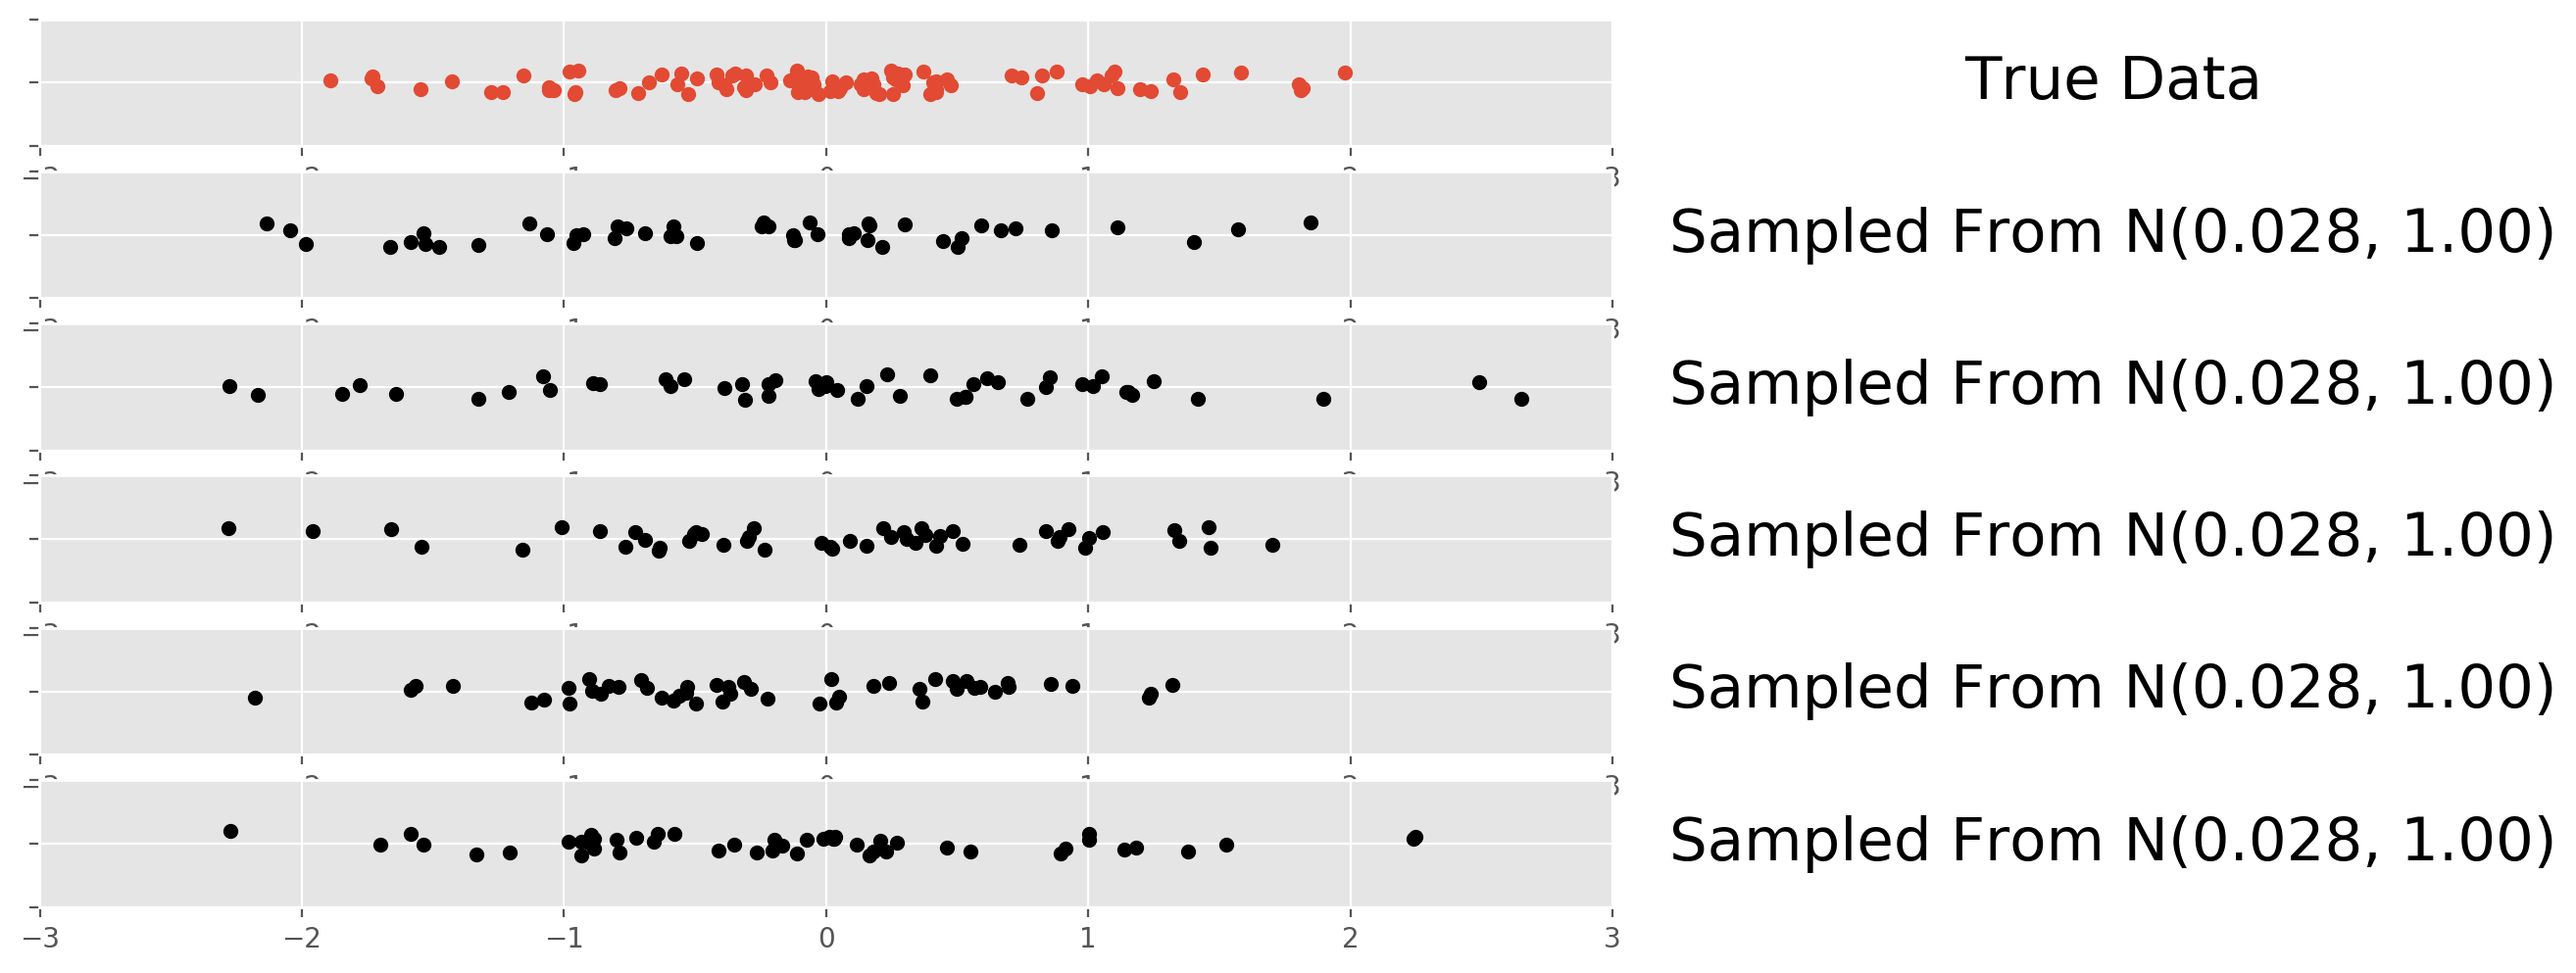

In [28]:
fig = plt.figure(figsize=(16, 6), dpi=200) 
ax = plt.subplot2grid((6, 3), (0, 0), colspan=2)
ax.set_xlim(-3, 3)
one_dim_scatterplot(data, ax, s=25)
ax = plt.subplot2grid((6, 3), (0, 2), colspan=1)
text_in_blank_plot("True Data", ax)

for i in range(5):
    normal = stats.norm(mu_hat, 1)
    sample = normal.rvs(50)
    ax = plt.subplot2grid((6, 3), (i + 1, 0), colspan=2)
    ax.set_xlim(-3, 3)
    one_dim_scatterplot(sample, ax, s=25, c="black")
    ax = plt.subplot2grid((6, 3), (i + 1, 2), colspan=1)
    text_in_blank_plot("Sampled From N({0:0.3f}, 1.00)".format(
                       mu_hat[0]), ax)

In [17]:
def superimpose_pdf_of_fit_model(data, model, ax, x_lower=-3, x_upper=3):
    x = np.linspace(x_lower, x_upper, num=250)
    _ = ax.hist(data, bins=25, density=True, color="black", alpha=0.4)
    ax.plot(x, model.pdf(x), linewidth=3)

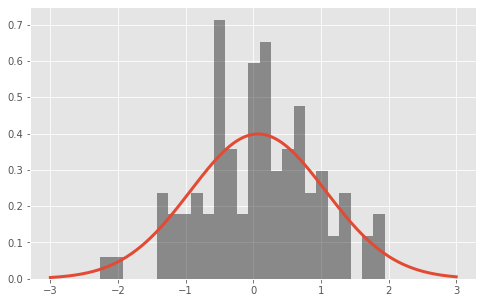

In [18]:
fit_one_param_model = stats.norm(mu_hat, 1.0)

fig, ax = plt.subplots(1, figsize=(8, 5))
superimpose_pdf_of_fit_model(data, fit_one_param_model, ax)

In [19]:
def superimpose_cdf_of_fit_model(data, model, ax, x_lower=-3, x_upper=3):
    x = np.linspace(x_lower, x_upper, num=250)
    ax.plot(x, empirical_distribution(x, data), linewidth=2)
    ax.plot(x, model.cdf(x), linewidth=2)

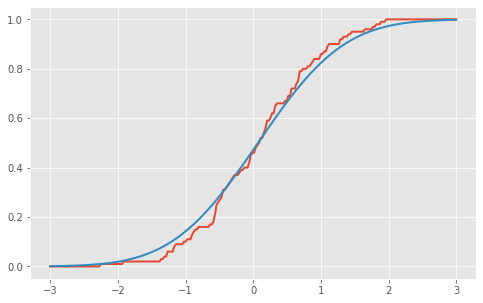

In [20]:
fig, ax = plt.subplots(1, figsize=(8, 5))
superimpose_cdf_of_fit_model(data, fit_one_param_model, ax)

### Further (manual) example: Normal Distribution, Unknown Mean and Variance

Let's reuse the normal data from before

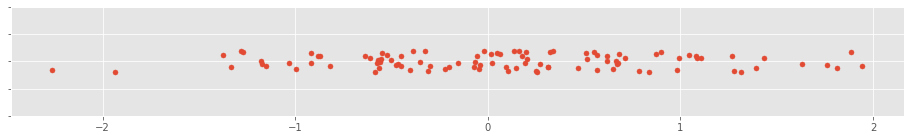

In [21]:
fig, ax = plt.subplots(1, figsize=(16, 2))
one_dim_scatterplot(data, ax, s=25)

And attempt to fit a normal distribution to this data using the likelihood method.

#### Step 1: Write down the model.

Our model contains all normal random variables with varying mean and variance.

$$ M = \{ N(\mu, \sigma^2) \mid \mu \in \mathbb{R}, \sigma^2 \in \mathbb{R}^+ \} $$

#### Step 2: Write down the density functions of all the random variables in the model.

The density function of a normal distribution with unknown mean and variance is:

$$ f(t; \mu, \sigma^2) = \frac{1}{\sqrt{2 \sigma^2 \pi}} e^{ - \frac{(t - \mu)^2}{2 \sigma^2}} $$

This pdf has arguments for both the **data** and the **parameters**:

$$ f(\underbrace{t}_{\text{data}}; \underbrace{\mu, \sigma^2}_{\text{parameters}}) $$

I can access this function in python by using `stats.norm(mu, sigma)`.

#### Step 3: Write code to compute the log likelihood function of the model given the data.

Remember that the data is *fixed* and we want to vary the *parameters*, so the way we write our function should respect that.

In [22]:
def log_likelihood_normal_two_parameters(mu, sigma_sq):
    normal = stats.norm(mu, np.sqrt(sigma_sq))
    likelihoods = [normal.pdf(datum) for datum in data]
    return np.sum(np.log(likelihoods))

As a sanity check, we can evaluate the log-likelihood function at varaious values of the parameters.

In [23]:
for mu, sigma_sq in product([-1, 0, 1], [0.5, 1, 2]):
    print("Log-Lik of Two Parameter Normal Model With mu={0}, sigma_sq={1}: {2:3.2f}".format(
        mu, sigma_sq, log_likelihood_normal_two_parameters(mu, sigma_sq)
    ))

Log-Lik of Two Parameter Normal Model With mu=-1, sigma_sq=0.5: -243.29
Log-Lik of Two Parameter Normal Model With mu=-1, sigma_sq=1: -184.92
Log-Lik of Two Parameter Normal Model With mu=-1, sigma_sq=2: -173.07
Log-Lik of Two Parameter Normal Model With mu=0, sigma_sq=0.5: -129.25
Log-Lik of Two Parameter Normal Model With mu=0, sigma_sq=1: -127.90
Log-Lik of Two Parameter Normal Model With mu=0, sigma_sq=2: -144.55
Log-Lik of Two Parameter Normal Model With mu=1, sigma_sq=0.5: -215.20
Log-Lik of Two Parameter Normal Model With mu=1, sigma_sq=1: -170.88
Log-Lik of Two Parameter Normal Model With mu=1, sigma_sq=2: -166.04


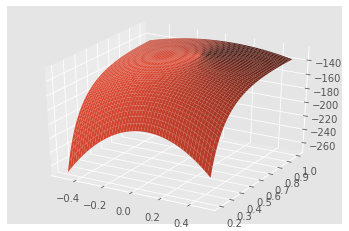

In [24]:
from mpl_toolkits.mplot3d import Axes3D
from pylab import meshgrid

mus = np.linspace(-0.5, 0.5, num=50)
sigmas = np.linspace(0.2, 1.0, num=50)

X, Y = meshgrid(mus, sigmas)
Z = np.array([
        [log_likelihood_normal_two_parameters(mu, sigma_sq)] 
         for mu, sigma_sq in zip(X.flatten(), Y.flatten())]).reshape(X.shape)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()

It looks like the the log-likelihood is maximized fo `mu=0, sigma_sq=0.5`, which seems reasonable given the plot of our data.

#### Step 4: Find the parameters that maximize the log-likelihood.

Eyeballing our simple grid search above, it seems like $\mu = 0, \sigma^2 = 0.5$ is the best of what we tried.

Let's use gradient descent to find the maximal parameters.

In [25]:
def minus_log_likelihood_normal_two_parameters(mu, sigma):
    return -log_likelihood_normal_two_parameters(mu, sigma)

# The optimizer needs a function that consumes a single numpy array
def wrapper_for_scipy(x):
    return minus_log_likelihood_normal_two_parameters(x[0], x[1])

fit_parms = optim.minimize(wrapper_for_scipy, (0, 1), method='Nelder-Mead')
mu_hat, sigma_sq_hat = fit_parms.x

print("Log-Lik Optimal Parameters: mu = {0:2.3f}, sigma_sq = {1:2.3f}".format(mu_hat, sigma_sq_hat))

Log-Lik Optimal Parameters: mu = 0.070, sigma_sq = 0.715


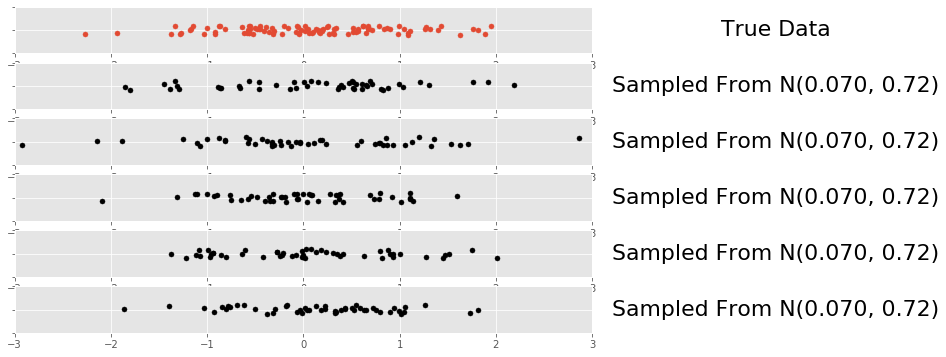

In [26]:
fig = plt.figure(figsize=(16, 6)) 
ax = plt.subplot2grid((6, 3), (0, 0), colspan=2)
ax.set_xlim(-3, 3)
one_dim_scatterplot(data, ax, s=25)
ax = plt.subplot2grid((6, 3), (0, 2), colspan=1)
text_in_blank_plot("True Data", ax)

for i in range(5):
    normal = stats.norm(mu_hat, np.sqrt(sigma_sq_hat))
    sample = normal.rvs(50)
    ax = plt.subplot2grid((6, 3), (i + 1, 0), colspan=2)
    ax.set_xlim(-3, 3)
    one_dim_scatterplot(sample, ax, s=25, c="black")
    ax = plt.subplot2grid((6, 3), (i + 1, 2), colspan=1)
    text_in_blank_plot("Sampled From N({0:0.3f}, {1:0.2f})".format(
                       mu_hat, sigma_sq_hat), ax)

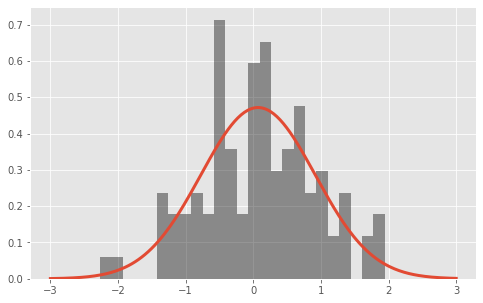

In [27]:
fit_two_param_model = stats.norm(mu_hat, np.sqrt(sigma_sq_hat))

fig, ax = plt.subplots(1, figsize=(8, 5))
superimpose_pdf_of_fit_model(data, fit_two_param_model, ax)

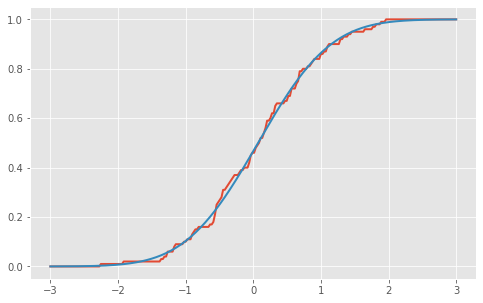

In [28]:
fig, ax = plt.subplots(1, figsize=(8, 5))
superimpose_cdf_of_fit_model(data, fit_two_param_model, ax)

### Are you ever going to have to do this?
In the assignment - yes.  
In practice - no.  In many cases the derivative of the log likelihood function has a [closed-form solution](http://statweb.stanford.edu/~susan/courses/s200/lectures/lect11.pdf), so you can set it equal to zero and solve for the parameters explicitly without trying ranges of parameters.  That's what's happening underneath the hood when you hear MLE is being used.  

But now you hopefully have some understanding of what's going on!

## Lecture Objectives

* Be able to explain what a statistical model is and why we use it.
* Understand that Maximum Likelihood Estimation (MLE) is a method used in statistics to determine statistical model parameters from data.  
* Be able to use MLE to estimate model parameters given a statistical model and data.
* Make you comfortable explaining MLE and using it.
* Give you some interesting Python to learn from in the process.